### Read in data

In [1]:
# import packages 
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import peak_local_max
#from toolz import pipe

In [264]:
# paths and filenames 
path = os.getcwd()
path_images = path + "\\test_images\\"
file_names = os.listdir(path_images)
print("Total files in dir: {0}".format(len(file_names)))

Total files in dir: 5


In [166]:
# read in the first image from the list of files
ret, image = cv2.imreadmulti(path_images+file_names[0], [], cv2.IMREAD_UNCHANGED)
print("Total slices in stack: {0}".format(len(image)))

Total slices in stack: 8


### Pick a skeletonised slice 

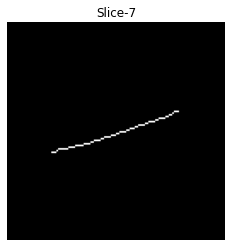

In [167]:
# working wth the seventh slice of this image
img = image[6]
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("Slice-7");

### Hough transform

A straight line parametrised with polar coordinates becomes:  
$$y = \frac{-\cos(\theta)}{\sin(\theta)} x + \frac{\rho}{\sin(\theta)}$$ 
since  
$$\rho = x\ \cos(\theta) + y\ \sin(\theta)$$

In [168]:
def hough_transform(img): 
    # initialise parameter space of all rhos and thetas
    n_y, n_x = img.shape[:]
    diag = int(np.sqrt(n_x**2 + n_y**2))
    
    # rhos range from -diagnoal to +diagonal of image 
    rhos = np.linspace(-diag, diag, 2*diag+1)
    n_rhos = len(rhos)
    # thetas range from [0, pi] or [-90, 90] radians
    thetas = np.deg2rad(np.arange(0, 180))
    n_thetas = len(thetas)

    # loop through line pixels 
    ### if image is binarised:
    nonzeros = np.argwhere(img==255)
    
    # Hough transform: get rho results 
    x = np.array(nonzeros[:,1])
    y = np.array(nonzeros[:,0])
    n_xys = nonzeros.shape[0]

    theta_mult = np.tile(thetas, n_xys).reshape((n_xys, n_thetas))
    cos_theta_mat = np.cos(theta_mult)
    sin_theta_mat = np.sin(theta_mult)
    rhos_res = (x.reshape(n_xys,1)*cos_theta_mat) + (y.reshape(n_xys,1)*sin_theta_mat)

    # get frequency of each (theta, rho) pair   
    ## theta vals == thetas 
    ## but rho_vals ranges from min(rho_res) to max(rho_res)
    accumulator = np.zeros((n_rhos, n_rhos))
    accumulator, theta_vals, rho_vals = np.histogram2d(
        np.tile(thetas, rhos_res.shape[0]),
        rhos_res.ravel(),
        bins = [n_thetas, n_rhos-1], ## when specifying n_bins, if n_thetas is n_thetas-1, thetas are off 
        range = [np.deg2rad([0,180]), [-diag, diag]])
    return accumulator, theta_vals, rho_vals

In [170]:
accumulator, theta_vals, rho_vals = hough_transform(img)

In [175]:
def conv_via_max(accumulator, theta_vals, rho_vals): 
    # index of maximum in accumulator
    ind = np.argwhere(accumulator==np.max(accumulator))[0]
    
    # get coordinates of line in cartesian coordinates
    rho_f = rho_vals[ind[1]]
    theta_f = theta_vals[ind[0]]
    cos_theta_f = np.cos(theta_f)
    sin_theta_f = np.sin(theta_f)

    xs = np.linspace(0, 127, 128) # assumes 128x128 image

    intercept = rho_f/sin_theta_f
    slope_x = np.array([(-cos_theta_f*xs)/sin_theta_f])

    ys = slope_x + intercept
    
    return xs, ys

In [176]:
xs, ys = conv_via_max(accumulator, theta_vals, rho_vals)

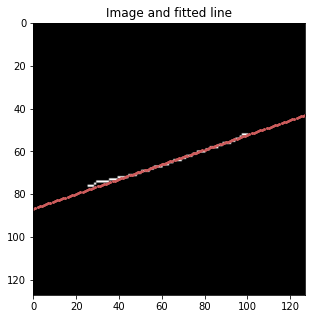

In [180]:
# overlay image with fitted line 
plt.figure(figsize=(5,5))
plt.imshow(img, cmap="gray")
x = np.array(img.shape[0])
plt.scatter(xs, ys, c="indianred", s=4)
plt.xlim(0,127)
plt.ylim(127,0)
plt.title("Image and fitted line")
plt.show()

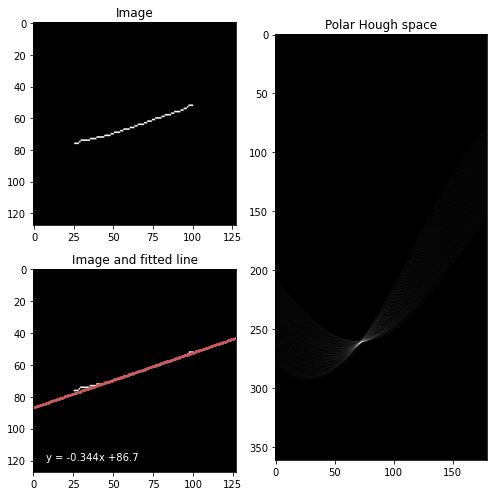

In [181]:
# plot image and pixel data side by side
fig = plt.figure(figsize=(7, 7))

fig.add_subplot(221)
plt.imshow(img, cmap="gray")
#plt.axis("off")
plt.title("Image");

fig.add_subplot(223)
plt.imshow(img, cmap="gray")
x = np.array(range(128))
plt.scatter(xs, ys, c="indianred", s=4)
plt.xlim(0,127)
plt.ylim(127,0)
plt.text(8, 120,
         ("y = " + str(np.round(-cos_theta_f/sin_theta_f, 3)) + "x +" + str(np.round(intercept, 1))),
         fontsize = 10, color = "white")
plt.title("Image and fitted line")

fig.add_subplot(122)
#plt.figure(figsize=(5,7))
plt.imshow(np.transpose(accumulator), cmap="gray");
plt.title("Polar Hough space");

plt.tight_layout()
#plt.savefig("figs\\image_fit_overlay_hough.png", format="png", dpi=600)

In [17]:
print("m = ", np.round(-cos_theta_f/sin_theta_f, 3), "    inteercept = ", np.round(intercept, 1))

m =  -0.344     inteercept =  86.7


In [ ]:
#np.matmul(np.transpose(np.matrix([2,2,3,3])), np.matrix([10,10,10]))
#np.matmul(np.transpose(np.array([2,2,3,3])), np.array([10,10,10]))

In [ ]:
# normalise image to avoid overflow when working with raw data
# normalise = (vals - min) / (max(vals - min))

### Linear regression

In [20]:
from sklearn.linear_model import LinearRegression

In [21]:
X = np.array(nonzeros[:,1]).reshape((-1,1))
Y = np.array(nonzeros[:,0])

In [23]:
model = LinearRegression().fit(X, Y)
print("R squared: ", np.round(model.score(X, Y), 4)) 
y_LR = model.predict(xs.reshape((-1, 1)))

R squared:  0.9915


In [26]:
# compare two fits
print("Hough transform:      m = ", np.round(-cos_theta_f/sin_theta_f, 3), 
      "    inteercept = ", np.round(intercept, 1))
print("Linear regression:    m = ", np.round(model.coef_[0], 3),
      "    inteercept = ", np.round(model.intercept_, 1))

Hough transform:      m =  -0.344     inteercept =  86.7
Linear regression:    m =  -0.324     inteercept =  85.4


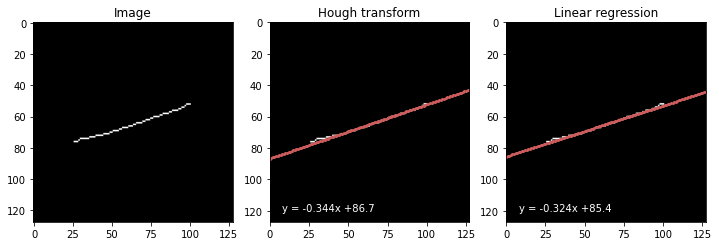

In [63]:
# plot image and pixel data side by side
fig = plt.figure(figsize=(10, 4))

# image 
fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
#plt.axis("off")
plt.title("Image");

# Hough transform result 
fig.add_subplot(1, 3, 2)
plt.imshow(img, cmap="gray")
x = np.array(range(128))
plt.scatter(xs, ys, c="indianred", s=4)
plt.xlim(0,127)
plt.ylim(127,0)
plt.text(8, 120,
         ("y = " + str(np.round(-cos_theta_f/sin_theta_f, 3)) + "x +" + str(np.round(intercept, 1))),
         fontsize = 10, color = "white")
plt.title("Hough transform")

fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap="gray")
x = np.array(range(128))
plt.scatter(xs, y_LR, c="indianred", s=4)
plt.xlim(0,127)
plt.ylim(127,0)
plt.text(8, 120,
         ("y = " + str(np.round(model.coef_[0], 3)) + "x +" + str(np.round(model.intercept_, 1))),
         fontsize = 10, color = "white")
plt.title("Linear regression")

plt.tight_layout()
#plt.savefig("figs\\Hough_transform_vs_Linear_regression.png", format="png", dpi=600)

### Detect multiple lines using local max detection algorithm

Total slices in stack: 8


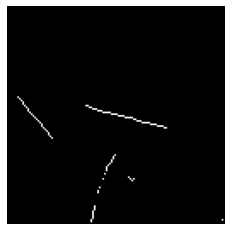

In [293]:
# read in the first image from the list of files
ret, image = cv2.imreadmulti(path_images+file_names[3], [], cv2.IMREAD_UNCHANGED)
print("Total slices in stack: {0}".format(len(image)))
img = image[6]
plt.imshow(img, cmap="gray")
plt.axis("off");

In [294]:
accumulator, theta_vals, rho_vals = hough_transform(img)

In [278]:
def conv_via_locmax(accumulator, theta_vals, rho_vals, min_dist = 20):
    # find local maxima 
    peaks = peak_local_max(accumulator, min_distance = min_dist)
    n_peaks = peaks.shape[0]
    print(n_peaks, "peaks:") 
    if n_peaks<10: print(peaks)
    
    n_x = 128
    xs = np.linspace(0, n_x-1, n_x)
    # get coordinates of line in cartesian coordinates
    rho_peaks = rho_vals[peaks[:,1]]
    theta_peaks = theta_vals[peaks[:,0]]

    cos_theta_peaks = np.cos(theta_peaks)
    sin_theta_peaks = np.sin(theta_peaks)

    intercept = rho_peaks/sin_theta_peaks
    slope_x = -cos_theta_peaks*np.tile(xs.reshape(n_x, 1), n_peaks) / sin_theta_peaks 

    ys = slope_x + intercept
    return(xs, ys, peaks)

In [298]:
xs, ys, peaks = conv_via_locmax(accumulator, theta_vals, rho_vals, 20)

5 peaks:
[[105 225]
 [140 210]
 [ 51 230]
 [ 20 208]
 [ 70 341]]


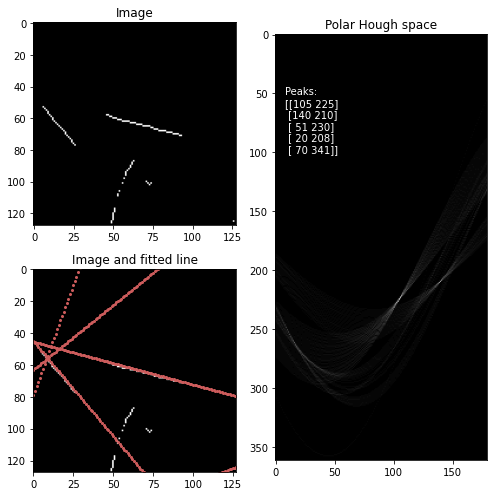

In [299]:
# plot image and pixel data side by side
fig = plt.figure(figsize=(7, 7))

fig.add_subplot(221)
plt.imshow(img, cmap="gray")
#plt.axis("off")
plt.title("Image");

fig.add_subplot(223)
plt.imshow(img, cmap="gray")
x = np.array(range(n_x))
for i in range(peaks.shape[0]):
    plt.scatter(xs, ys[:,i], c="indianred", s=4)
plt.xlim(0,127)
plt.ylim(127,0)
#plt.text(8, 120,
#         ("y = " + str(np.round(-cos_theta_f/sin_theta_f, 3)) + "x +" + str(np.round(intercept, 1))),
#         fontsize = 10, color = "white")
plt.title("Image and fitted line");

fig.add_subplot(122)
#plt.figure(figsize=(5,7))
plt.imshow(np.transpose(accumulator), cmap="gray");
plt.text(8, 100,("Peaks:\n"+str(peaks)),
         fontsize = 10, color = "white")
plt.title("Polar Hough space");

plt.tight_layout()
#plt.savefig("figs\\image_fit_overlay_hough.png", format="png", dpi=600)